# Section 6a: Job Submissions, Runtime and Energy

In [1]:
import pyspark.sql.functions as F
from util.read_and_print_df import *
from util.handle_nan import *
from util.extract_json_attributes import *
from util.plotting import *
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import matplotlib.image as mpimg

In [3]:
spark = get_spark_session()

Assigning 541 GB of memory per spark driver and executor, and use 126 cores.


In [5]:
df_prom_slurm = spark.read.parquet(path_job_node_joined_dataset)
df_prom_slurm = df_prom_slurm.withColumn("job_duration_seconds", F.unix_timestamp('end_date') - F.unix_timestamp('start_date'))
df_prom_slurm = df_prom_slurm.orderBy('prom_id', 'timestamp')
df_prom_slurm.show(5, False)

+-------+-------------------+-----+-----------------+-----------+----------------+---+------------------------+-----------------------+---------------------------+----------+----------+------------------------+----------------------------+-------------------------+-----------------------+-----------------+------------------------+----------------------------+---------------+-----------------------+------------------------+----------------------+-----------------------------+--------------------------+------------------+-------------------------+-------------------------+------------------+----------------+---------------------------+----------------------------+---------------------------+-------------------------------+-------------------------+-------------------------------------+--------------------------------+---------------------------------+------------------------------+--------------------------+---------------------------+--------------------------+--------------------------

Job submissions

In [6]:
df_prom_slurm_submissions = df_prom_slurm.groupBy('slurm_id').agg(
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state'),
).groupBy('gpu_node', 'state').agg(F.count(F.lit(1)).alias('submissions')).orderBy('gpu_node', 'state')

df_prom_slurm_submissions.show(20, False)

+--------+-------------+-----------+
|gpu_node|state        |submissions|
+--------+-------------+-----------+
|0       |CANCELLED    |9592       |
|0       |COMPLETED    |202874     |
|0       |FAILED       |37588      |
|0       |NODE_FAIL    |1426       |
|0       |OUT_OF_MEMORY|4499       |
|0       |TIMEOUT      |10625      |
|1       |CANCELLED    |3669       |
|1       |COMPLETED    |17306      |
|1       |FAILED       |4664       |
|1       |NODE_FAIL    |107        |
|1       |OUT_OF_MEMORY|130        |
|1       |TIMEOUT      |1411       |
+--------+-------------+-----------+



Job Runtimes

In [7]:
df_prom_slurm_job_runtimes = df_prom_slurm.groupBy('slurm_id').agg(
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state'),
    F.first('job_duration_seconds').alias('job_duration_seconds')
).groupBy('gpu_node', 'state').agg(
    F.sum('job_duration_seconds').alias('job_runtime_seconds_total')
).orderBy('gpu_node', 'state')

df_prom_slurm_job_runtimes.show(20, False)

+--------+-------------+-------------------------+
|gpu_node|state        |job_runtime_seconds_total|
+--------+-------------+-------------------------+
|0       |CANCELLED    |159244129                |
|0       |COMPLETED    |1174110581               |
|0       |FAILED       |104202113                |
|0       |NODE_FAIL    |50619879                 |
|0       |OUT_OF_MEMORY|20326239                 |
|0       |TIMEOUT      |534482534                |
|1       |CANCELLED    |70772672                 |
|1       |COMPLETED    |208631259                |
|1       |FAILED       |19230007                 |
|1       |NODE_FAIL    |845166                   |
|1       |OUT_OF_MEMORY|2248610                  |
|1       |TIMEOUT      |111294276                |
+--------+-------------+-------------------------+



Job Energy

In [8]:
df_prom_slurm_energy = df_prom_slurm.join(
    df_prom_slurm.groupBy('node', 'timestamp').agg(F.count(F.lit(1)).alias('concurrent_job_count')), ['node', 'timestamp'], how='left'
).withColumn('node_power_usage_per_job_per_node_per_timestamp', col('node_power_usage') / col('concurrent_job_count')) \
.groupBy('slurm_id', 'node').agg(
    F.mean('node_power_usage_per_job_per_node_per_timestamp').alias('node_power_usage_per_job_per_node_mean'),
    F.first('job_duration_seconds').alias('job_duration_seconds'),
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state')
).withColumn('node_energy_usage_per_job_per_node', F.col('node_power_usage_per_job_per_node_mean') * F.col('job_duration_seconds')) \
.groupBy('slurm_id').agg(
    F.sum('node_energy_usage_per_job_per_node').alias('node_energy_usage_per_job'),
    F.first('gpu_node').alias('gpu_node'),
    F.first('state').alias('state')
).groupBy('gpu_node', 'state').agg(
    F.sum('node_energy_usage_per_job').alias('node_energy_usage_per_nodetype_per_state')
).orderBy('gpu_node', 'state')

df_prom_slurm_energy.show(20, False)

+--------+-------------+----------------------------------------+
|gpu_node|state        |node_energy_usage_per_nodetype_per_state|
+--------+-------------+----------------------------------------+
|0       |CANCELLED    |2.658925779628305E10                    |
|0       |COMPLETED    |1.377435808060837E11                    |
|0       |FAILED       |1.0661996749175968E10                   |
|0       |NODE_FAIL    |7.603104488755941E9                     |
|0       |OUT_OF_MEMORY|2.2797041191898007E9                    |
|0       |TIMEOUT      |8.517718885303772E10                    |
|1       |CANCELLED    |2.9534506993850616E10                   |
|1       |COMPLETED    |8.315266117146094E10                    |
|1       |FAILED       |7.945788024926845E9                     |
|1       |NODE_FAIL    |4.4316968978609633E8                    |
|1       |OUT_OF_MEMORY|1.7887963345175433E9                    |
|1       |TIMEOUT      |4.749171268834755E10                    |
+--------+

Join all submisions, runtimes and energy dataframes

In [9]:
df_prom_slurm_sub_run_energy = df_prom_slurm_submissions.join(
    df_prom_slurm_job_runtimes, ['gpu_node', 'state'], 'inner').join(df_prom_slurm_energy, ['gpu_node', 'state'], 'inner'
).orderBy('gpu_node', 'state')

df_prom_slurm_sub_run_energy.show(20, False)

+--------+-------------+-----------+-------------------------+----------------------------------------+
|gpu_node|state        |submissions|job_runtime_seconds_total|node_energy_usage_per_nodetype_per_state|
+--------+-------------+-----------+-------------------------+----------------------------------------+
|0       |CANCELLED    |9592       |159244129                |2.658925779628305E10                    |
|0       |COMPLETED    |202874     |1174110581               |1.377435808060837E11                    |
|0       |FAILED       |37588      |104202113                |1.0661996749175968E10                   |
|0       |NODE_FAIL    |1426       |50619879                 |7.603104488755941E9                     |
|0       |OUT_OF_MEMORY|4499       |20326239                 |2.2797041191898007E9                    |
|0       |TIMEOUT      |10625      |534482534                |8.517718885303772E10                    |
|1       |CANCELLED    |3669       |70772672                 |2.

In [10]:
df_prom_slurm_sub_run_energy_pd = df_prom_slurm_sub_run_energy.toPandas()

df_prom_slurm_sub_run_energy_pd = df_prom_slurm_sub_run_energy_pd.rename(
    columns={'submissions': 'Job Submissions', 'job_runtime_seconds_total': 'Job Runtime', 'node_energy_usage_per_nodetype_per_state': 'Job Energy Usage'}
    )

df_prom_slurm_sub_run_energy_pd

,gpu_node,state,Job Submissions,Job Runtime,Job Energy Usage
0,0,CANCELLED,9592,159244129,2.658926e+10
1,0,COMPLETED,202874,1174110581,1.377436e+11
2,0,FAILED,37588,104202113,1.066200e+10
3,0,NODE_FAIL,1426,50619879,7.603104e+09
4,0,OUT_OF_MEMORY,4499,20326239,2.279704e+09
5,0,TIMEOUT,10625,534482534,8.517719e+10
6,1,CANCELLED,3669,70772672,2.953451e+10
7,1,COMPLETED,17306,208631259,8.315266e+10
8,1,FAILED,4664,19230007,7.945788e+09
9,1,NODE_FAIL,107,845166,4.431697e+08


In [11]:
def plot_horizontal_stacked_bar_with_hatches(df, columns, file_path, ax=None, plot_legend=True):

    df_pd = df.copy()
    plt.figure(figsize=(14, 14))

    for c in columns:
        df_pd[c] = df_pd[c] / df_pd[c].sum()

    df_pd.set_index('state', inplace=True, drop=True)
    display(df_pd)

    df_pd = df_pd[df_pd.columns[::-1]]
    df_pd = df_pd.drop(columns='gpu_node')
    df_pd = df_pd.T

    column_order = ['COMPLETED', 'FAILED', 'CANCELLED', 'TIMEOUT', 'OUT_OF_MEMORY', 'NODE_FAIL']
    df_pd = df_pd[column_order]

    colors = sns.color_palette('colorblind', n_colors=len(column_order))
    width = 0.75

    if ax is None:
        ax = df_pd.plot(kind='barh', stacked=True, color=colors, width=width)
    else:
        df_pd.plot(kind='barh', stacked=True, color=colors, ax=ax, width=width)

    hatches = ['.', '/', '+', '\\', '*', 'x']

    # Add hatch patterns to the bars
    for i, bar in enumerate(ax.patches):
        # For every possible job state, 2 subsequent bars are created in ax.patches, one for each job type (generic, ML)
        # Set bars pairwise (same job state) to the same hatch pattern
        bar.set_hatch(hatches[i // len(columns)])

    plt.xlabel("Fraction of Total Values")
        
    if plot_legend:
        # reorder legend entries
        handles, labels = ax.get_legend_handles_labels()
        handles = [handles[0], handles[3], handles[1], handles[4], handles[2], handles[5]]
        labels = [labels[0], labels[3], labels[1], labels[4], labels[2], labels[5]]
        ax.legend(handles, labels, title='Job State', ncol=3, loc='upper center', bbox_to_anchor=(0.4, 1.9))
    else:
        ax.get_legend().remove()


    plt.savefig(f'{file_path}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{file_path}.pdf', bbox_inches='tight')

    plt.show()

,gpu_node,Job Submissions,Job Runtime,Job Energy Usage
state,,,,
CANCELLED,0,0.035978,0.077947,0.098459
COMPLETED,0,0.760956,0.574703,0.510058
FAILED,0,0.140988,0.051005,0.039481
NODE_FAIL,0,0.005349,0.024777,0.028154
OUT_OF_MEMORY,0,0.016875,0.009949,0.008442
TIMEOUT,0,0.039853,0.261618,0.315407


<Figure size 1400x1400 with 0 Axes>

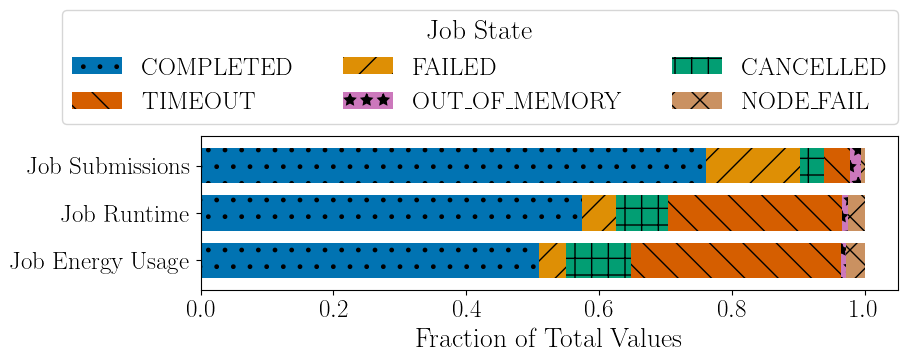

In [12]:
set_one_column_figure_font(height_multiplier=0.40)

df_prom_slurm_sub_run_energy_pd_generic = df_prom_slurm_sub_run_energy_pd[df_prom_slurm_sub_run_energy_pd['gpu_node'] == 0]
plot_horizontal_stacked_bar_with_hatches(df_prom_slurm_sub_run_energy_pd_generic, columns=df_prom_slurm_sub_run_energy_pd_generic.columns[-3:], file_path='plots/section_6/job_submissions_runtime_energy_generic', plot_legend=True)

,gpu_node,Job Submissions,Job Runtime,Job Energy Usage
state,,,,
CANCELLED,1,0.134460,0.171353,0.173369
COMPLETED,1,0.634221,0.505134,0.488109
FAILED,1,0.170924,0.046559,0.046642
NODE_FAIL,1,0.003921,0.002046,0.002601
OUT_OF_MEMORY,1,0.004764,0.005444,0.010500
TIMEOUT,1,0.051710,0.269463,0.278778


<Figure size 1400x1400 with 0 Axes>

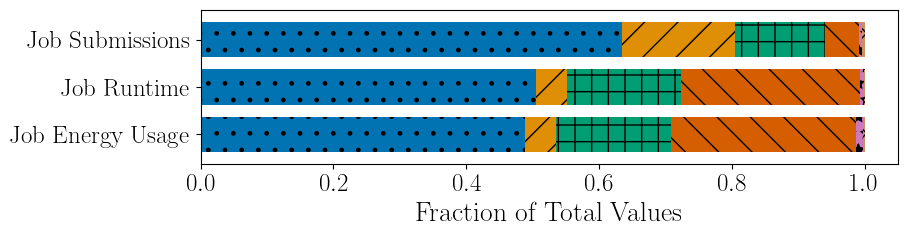

In [13]:
set_one_column_figure_font(height_multiplier=0.40)

df_prom_slurm_sub_run_energy_pd_ml = df_prom_slurm_sub_run_energy_pd[df_prom_slurm_sub_run_energy_pd['gpu_node'] == 1]
plot_horizontal_stacked_bar_with_hatches(df_prom_slurm_sub_run_energy_pd_ml, columns=df_prom_slurm_sub_run_energy_pd_ml.columns[-3:], file_path='plots/section_6/job_submissions_runtime_energy_ml', plot_legend=False)